# Chen Analysis with scanpy

Use scanpy to analyze kallisto output from alignment of chen data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.2


In [3]:
results_file = 'schen-scrnqseq.h5ad'  # the file that will store the analysis results

Import Data

In [4]:
folder = '/mnt/labshare/ravi/scrna-seq/chen-reanalysis/polyg_trimmed_all_bus_output/genecount/'

In [5]:
mm10_names = pd.read_table('/home/rmandla/Downloads/mm10_genenames.txt')

In [6]:
scrna_ensembl = pd.read_csv(folder+'gene.genes.txt',header=None)

In [7]:
mm10_names = mm10_names[mm10_names['Gene stable ID version'].isin(scrna_ensembl[0])].drop_duplicates('Gene stable ID version').set_index('Gene stable ID version')

In [8]:
scrna_ensembl = scrna_ensembl.set_index(0)
scrna_ensembl['gene name'] = mm10_names['Gene name']

In [9]:
all_nans = scrna_ensembl[scrna_ensembl['gene name'].isnull()]
all_nans['gene name'] = all_nans.index

<ipython-input-9-35ae948c0ff1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nans['gene name'] = all_nans.index


In [10]:
fixed_scrna = pd.concat([scrna_ensembl.dropna(),all_nans])
fixed_scrna = fixed_scrna.reindex(index = scrna_ensembl.index)

In [11]:
adata = sc.read_mtx(folder + "gene.mtx")
adata.obs.index = pd.read_csv(folder + "gene.barcodes.txt", header=None)[0].values
adata.var.index = fixed_scrna['gene name'].values

filter from knee plot

In [12]:
adata

AnnData object with n_obs × n_vars = 570931 × 36047

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 560751 cells that have less than 200 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 15426 genes that are detected in less than 3 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
adata

AnnData object with n_obs × n_vars = 10180 × 20621
    obs: 'n_genes'
    var: 'n_cells'

Generate qc plots (genes per count + total count + counts of mt genes)

In [15]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home

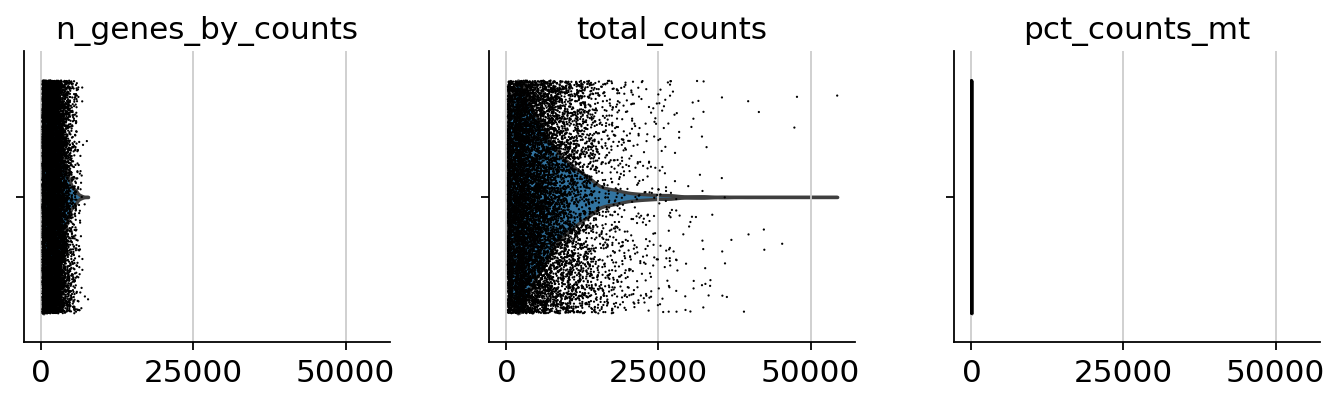

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)



no mitochondrial genes :)

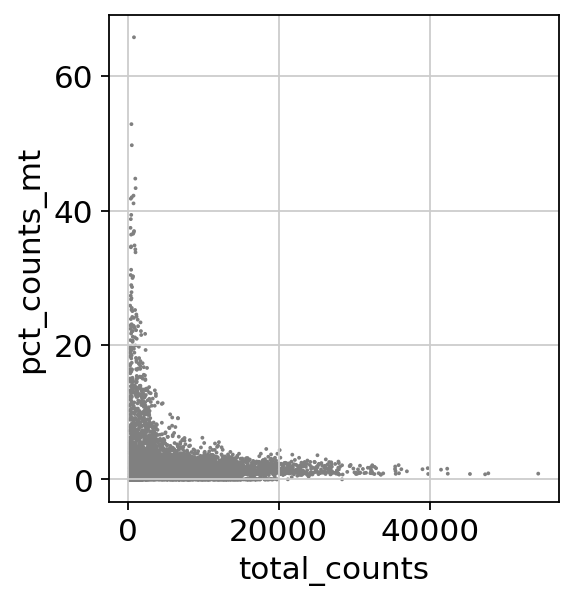

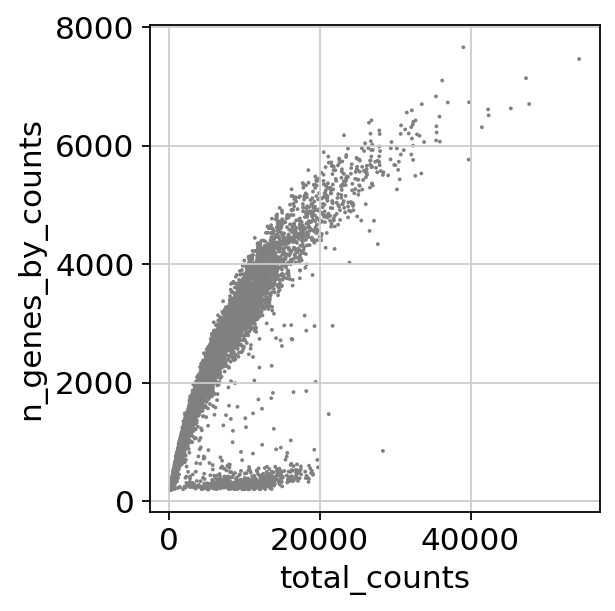

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Remove cells with too few genes per count

In [18]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

normalize and log data

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/rmandla/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


normalizing counts per cell
    finished (0:00:00)


Highly variable genes...

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


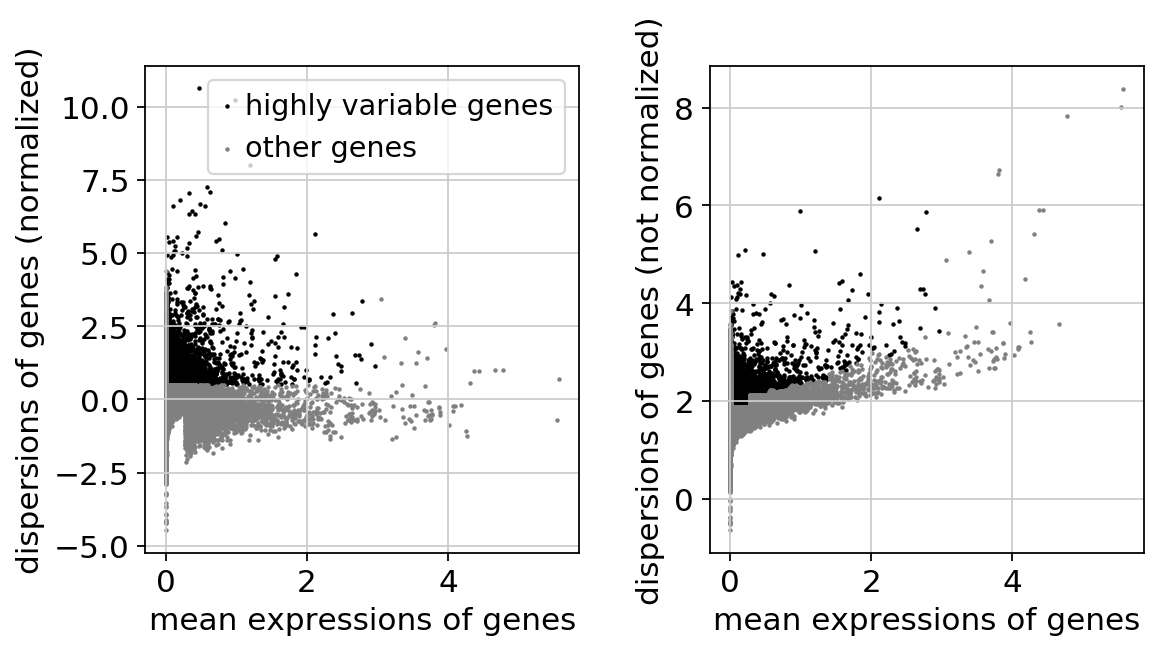

In [21]:
sc.pl.highly_variable_genes(adata)

Set raw value to normalized computed values

In [22]:
adata.raw = adata

Filter highly variable genes

In [23]:
adata = adata[:, adata.var.highly_variable]

regress out effects and scale to unit variance

In [24]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:35)


In [25]:
sc.pp.scale(adata, max_value=10)

## PCA

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


In [27]:
adata

AnnData object with n_obs × n_vars = 6343 × 4855
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

color for myh6

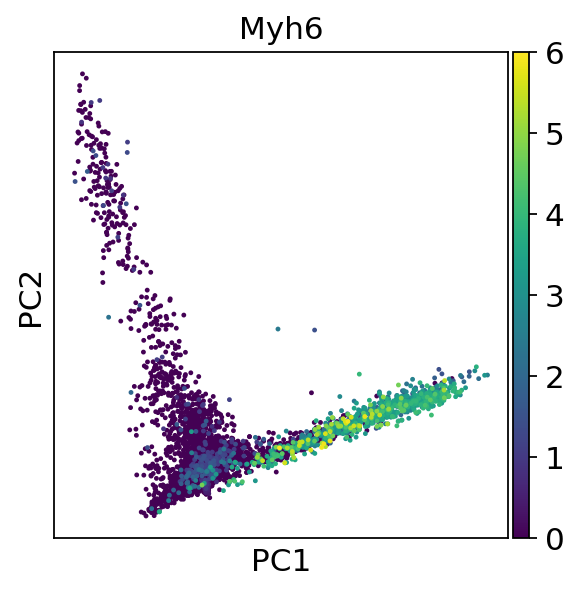

In [28]:
sc.pl.pca(adata, color='Myh6')

Effects of pca analysis...

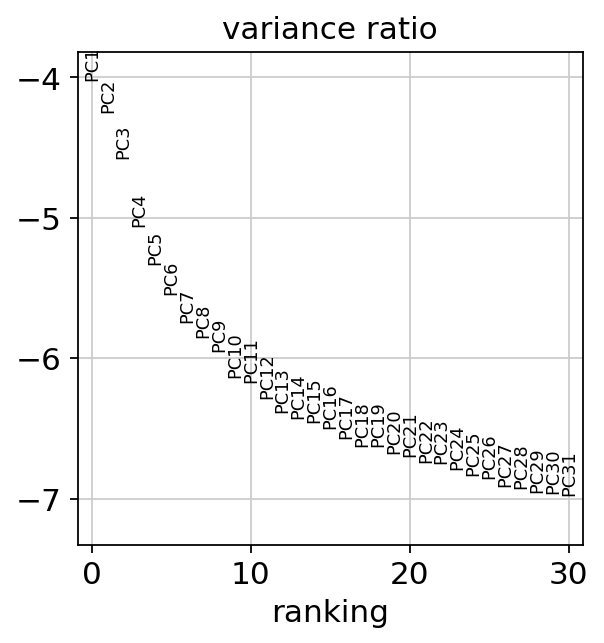

In [29]:
sc.pl.pca_variance_ratio(adata, log=True)

Save data

In [30]:
adata.write(results_file)

In [31]:
adata

AnnData object with n_obs × n_vars = 6343 × 4855
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

generate neighbor calculation. using default values in tutorial for now

In [32]:
sc.pp.neighbors(adata,n_neighbors=64,n_pcs=21)

computing neighbors
    using 'X_pca' with n_pcs = 21
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


Using umap instead of tsne...

In [33]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


Clustering analysis

In [34]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


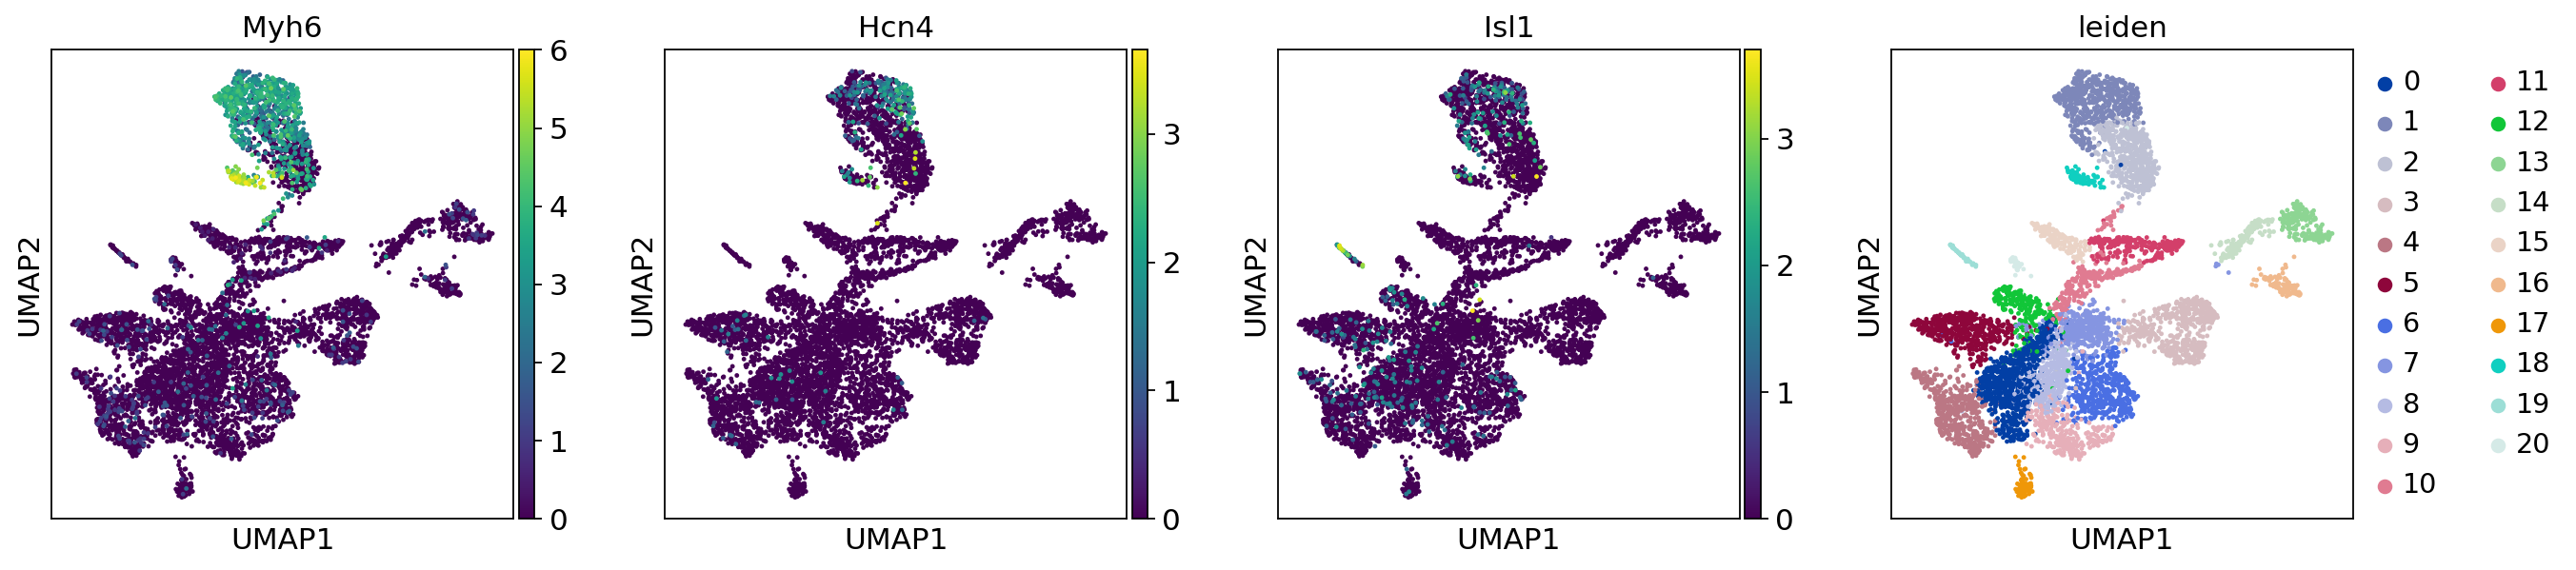

In [35]:
sc.pl.umap(adata, color=['Myh6', 'Hcn4', 'Isl1', 'leiden'])

/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla

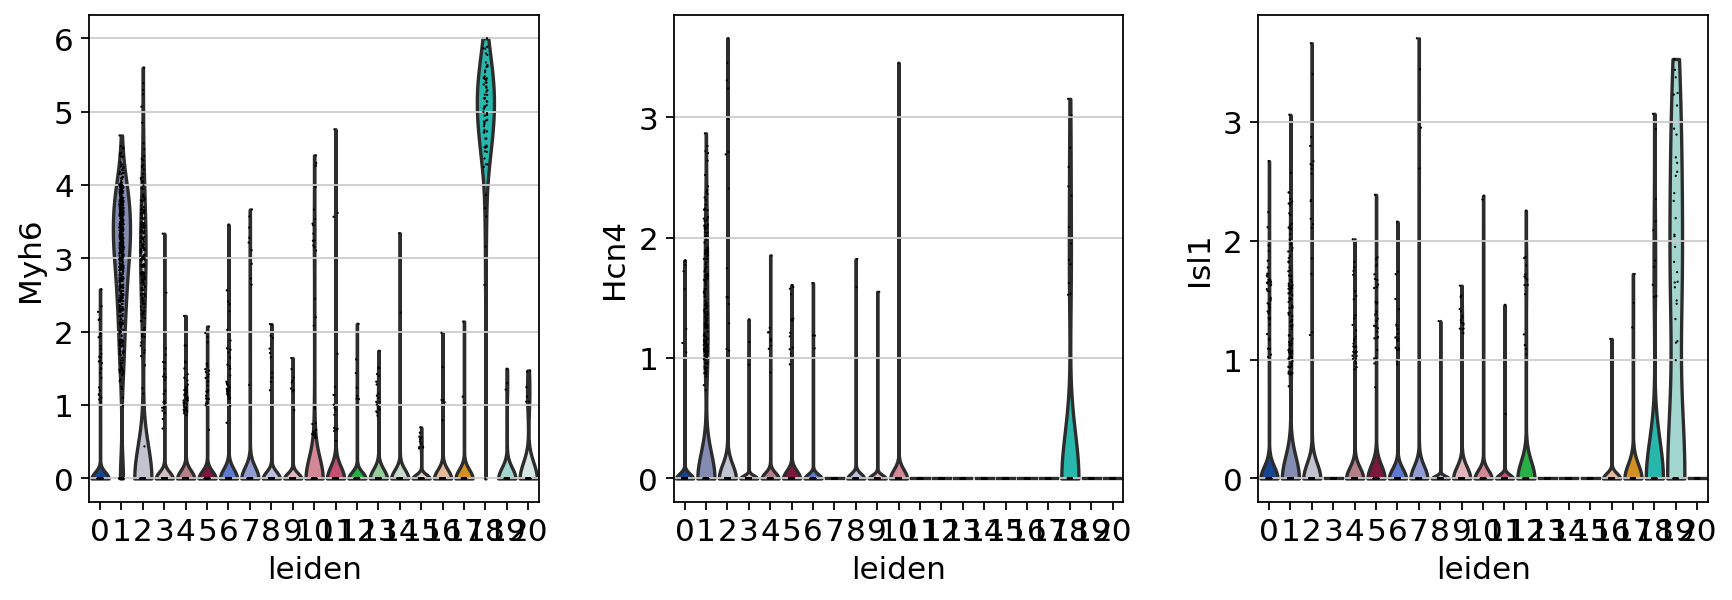

In [38]:
sc.pl.violin(adata, ['Myh6','Hcn4','Isl1'], groupby='leiden')

In [39]:
adata.write(results_file, compression='gzip')

Subcluster group 1 and 2

In [40]:
adata_subset = adata[adata.obs['leiden'].isin(['1','2'])]

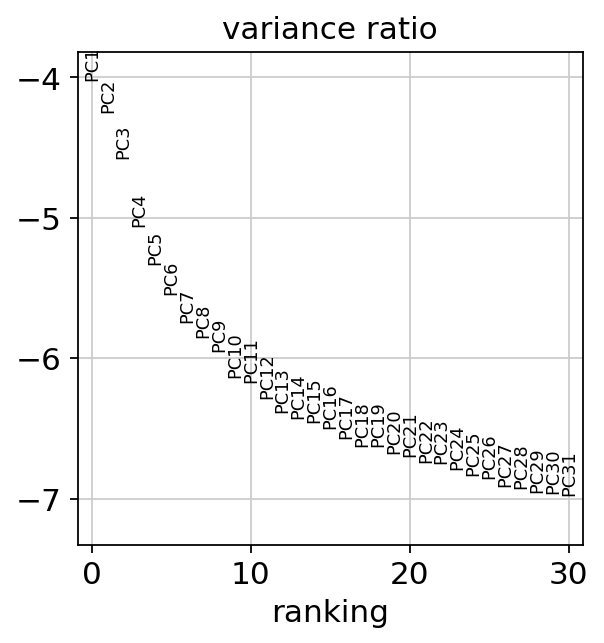

In [41]:
sc.pl.pca_variance_ratio(adata_subset, log=True,n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


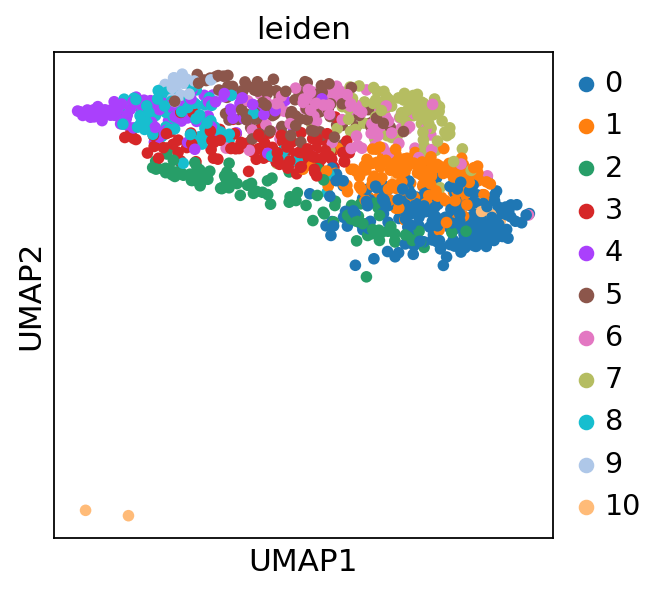

In [42]:
sc.pp.neighbors(adata_subset)
sc.tl.leiden(adata_subset)
sc.pl.umap(adata_subset, color=['leiden'])

/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla

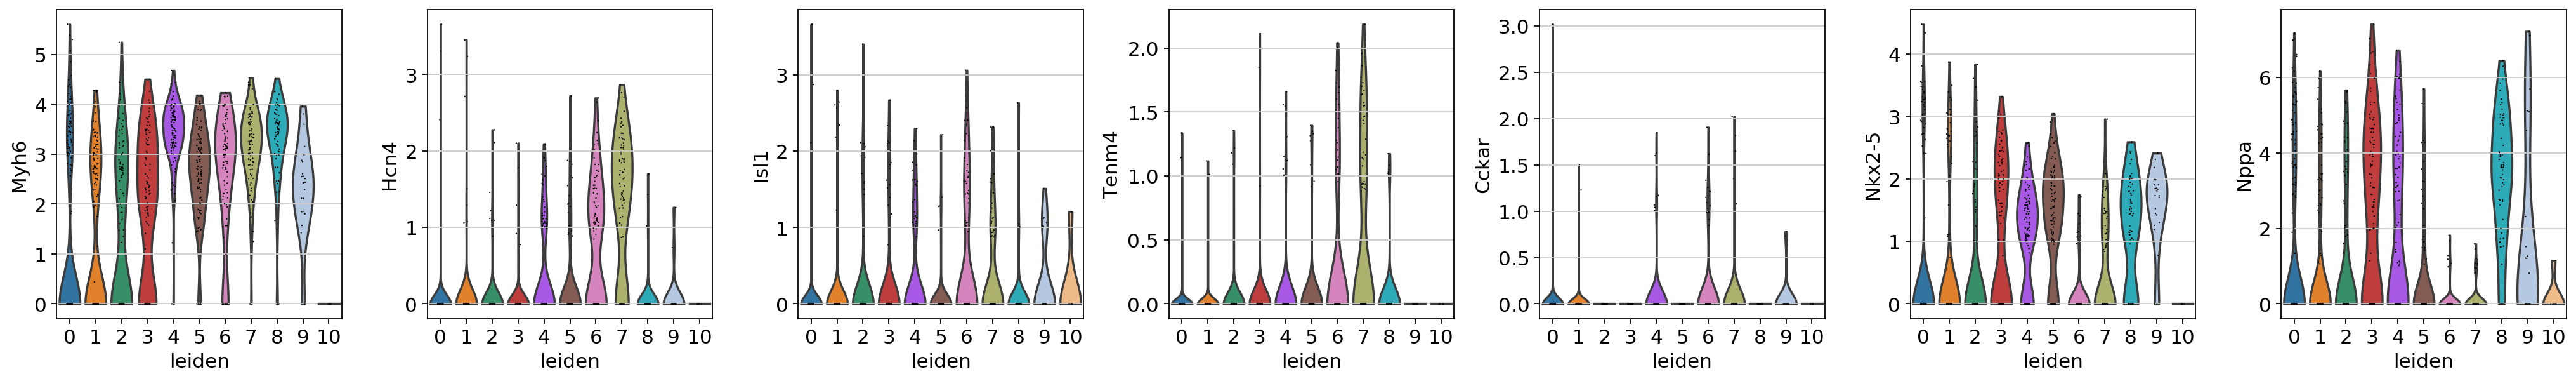

In [43]:
sc.pl.violin(adata_subset, ['Myh6','Hcn4','Isl1','Tenm4','Cckar','Nkx2-5','Nppa'], groupby='leiden')

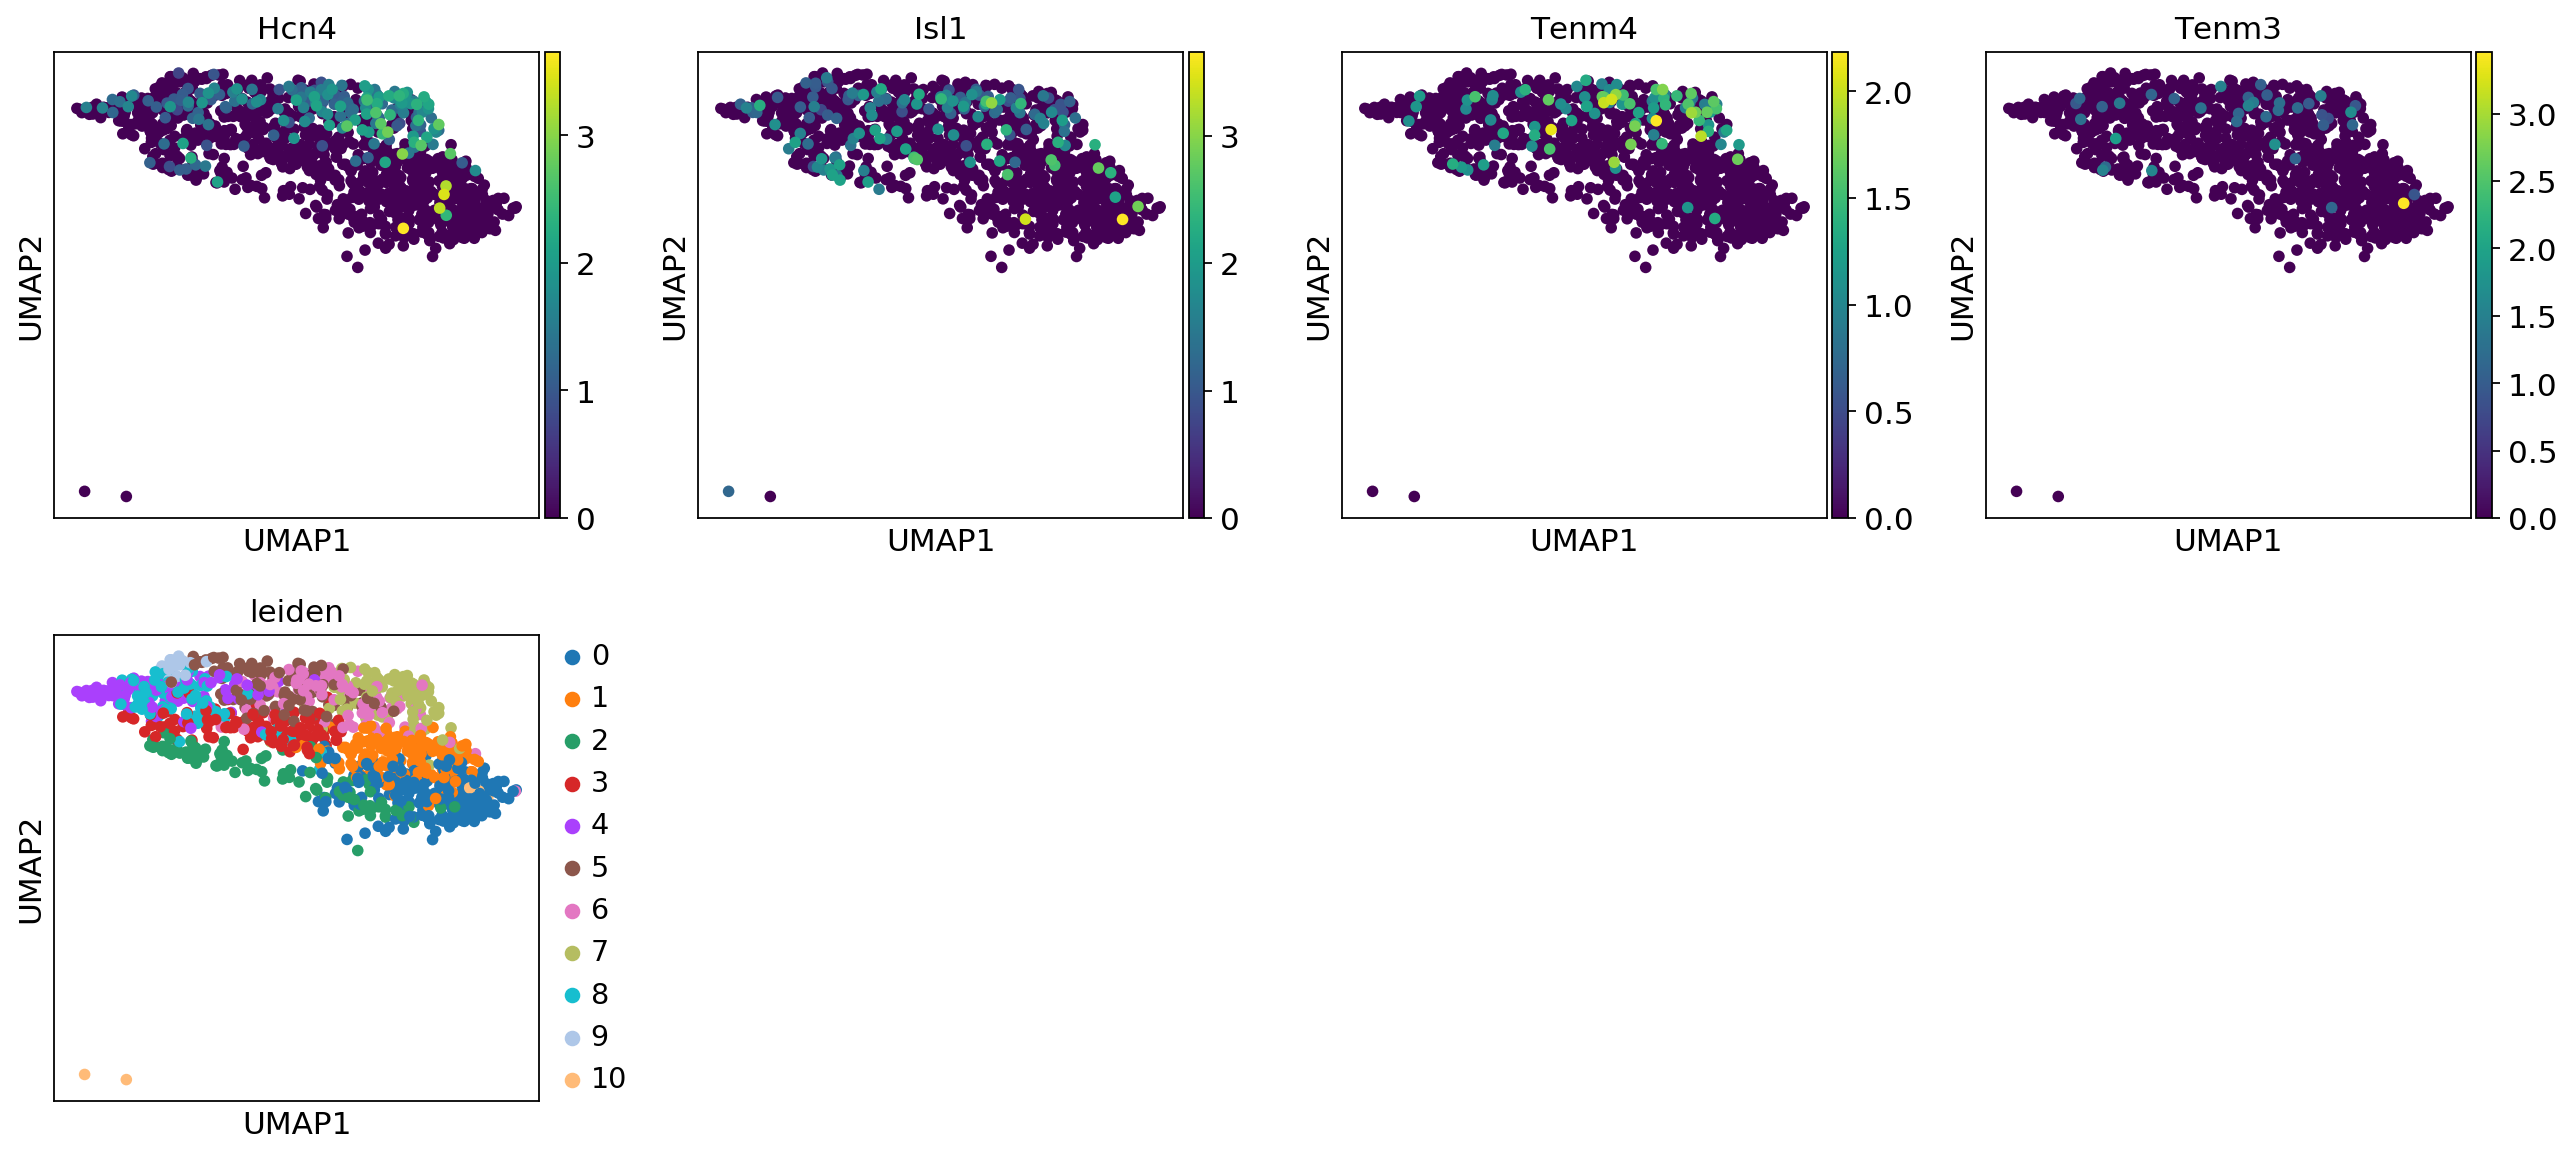

In [44]:
sc.pl.umap(adata_subset, color=['Hcn4', 'Isl1','Tenm4','Tenm3','leiden'])

In [45]:
adata_subsubset = adata_subset[adata_subset.obs['leiden'].isin(['6','7'])]

Tenm4 and Tenm3 co-expression

In [46]:
matrix = adata_subsubset.raw.X.todense()
array = np.asarray(matrix)

In [47]:
tenm3 = []
tenm4 = []
for i in array:
    tenm3.append(i[list(adata_subsubset.raw.var.index).index('Tenm3')])
    tenm4.append(i[list(adata_subsubset.raw.var.index).index('Tenm4')])

In [48]:
t3t4 = pd.DataFrame({'Tenm3':tenm3,'Tenm4':tenm4})

In [49]:
sum(t3t4['Tenm3']>=1.0)

18

In [50]:
sum(t3t4['Tenm4']>=1.0)

45

In [51]:
len(t3t4[(t3t4['Tenm3'] < 1.0) & (t3t4['Tenm4'] >= 1.0)])

35

In [52]:
t3t4['Tenm3'].corr(t3t4['Tenm4'])

0.18507537481697553

In [53]:
t3t4

,Tenm3,Tenm4
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,1.230194,0.000000
4,0.000000,0.000000
...,...,...
174,0.000000,0.000000
175,0.000000,0.000000
176,0.000000,0.000000
177,0.000000,1.702379


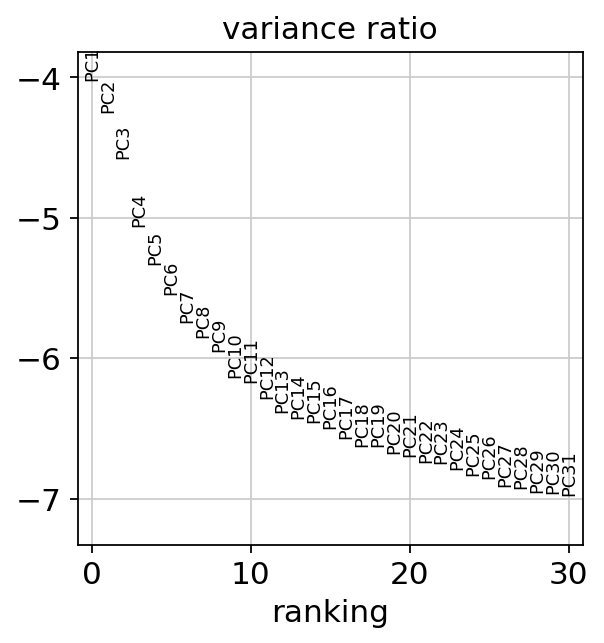

In [54]:
sc.pl.pca_variance_ratio(adata_subsubset, log=True,n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


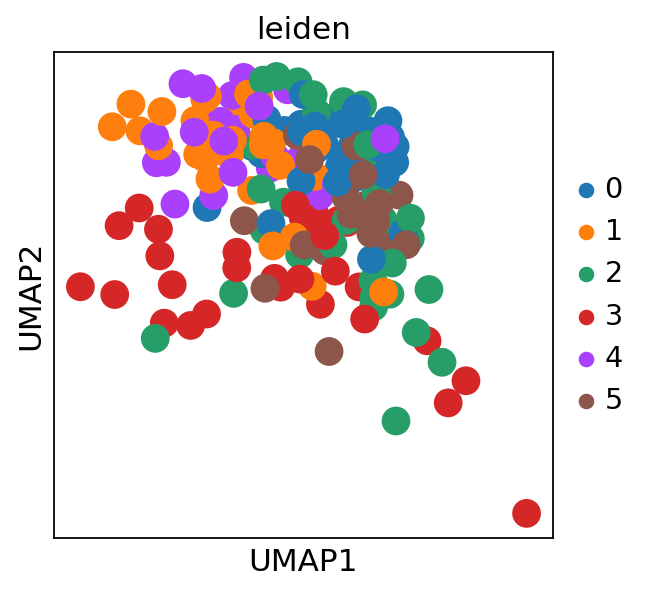

In [55]:
sc.pp.neighbors(adata_subsubset)
sc.tl.leiden(adata_subsubset)
sc.pl.umap(adata_subsubset, color=['leiden'])

/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rmandla

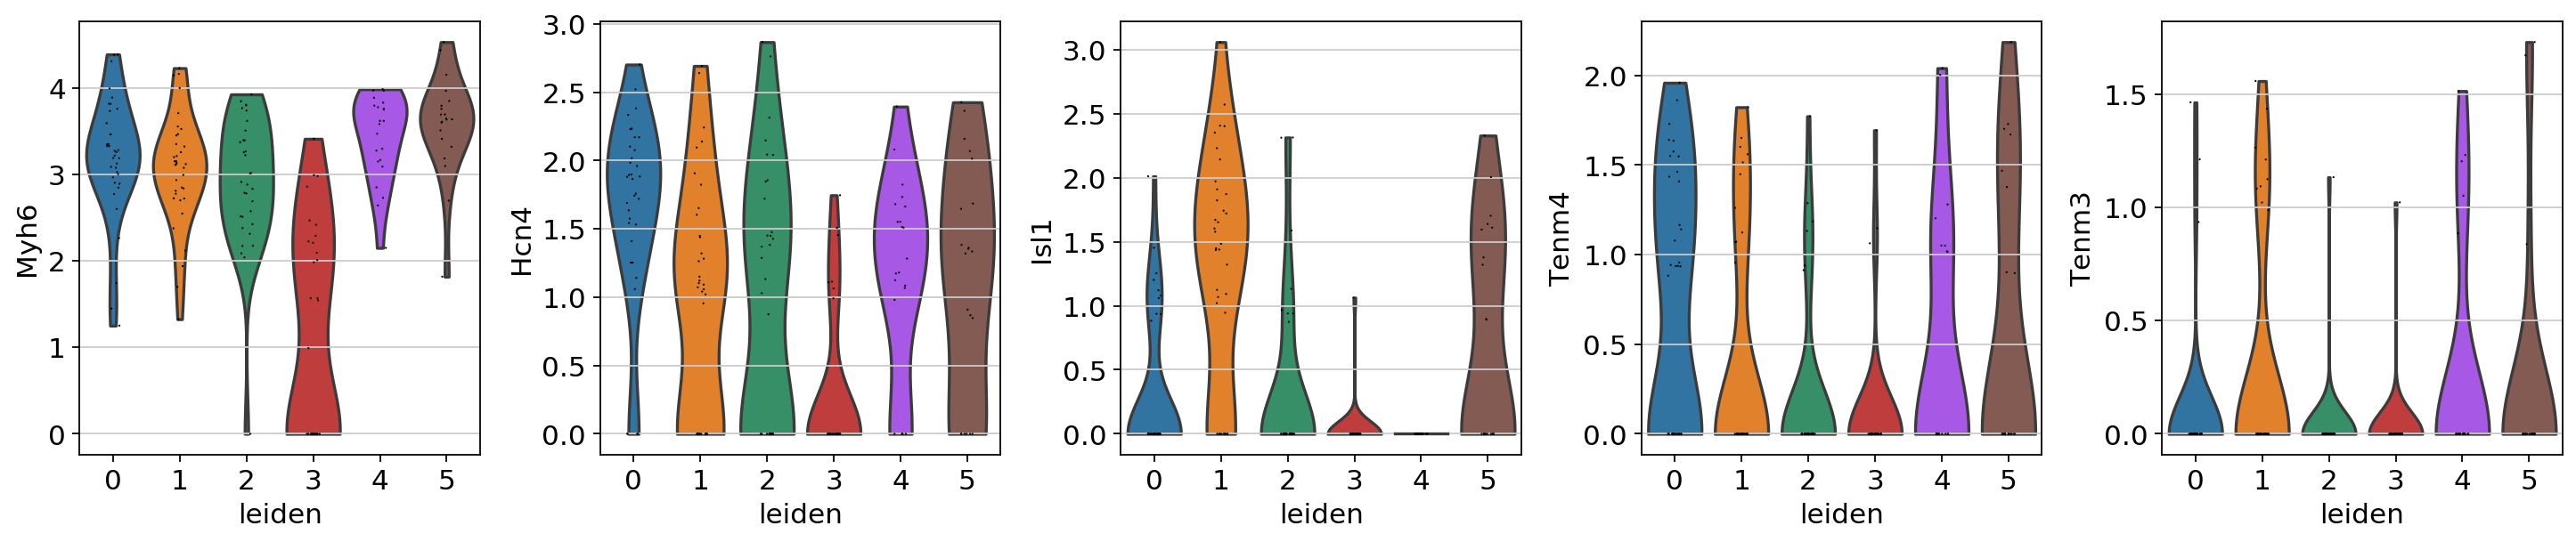

In [56]:
sc.pl.violin(adata_subsubset, ['Myh6','Hcn4','Isl1','Tenm4','Tenm3'], groupby='leiden')

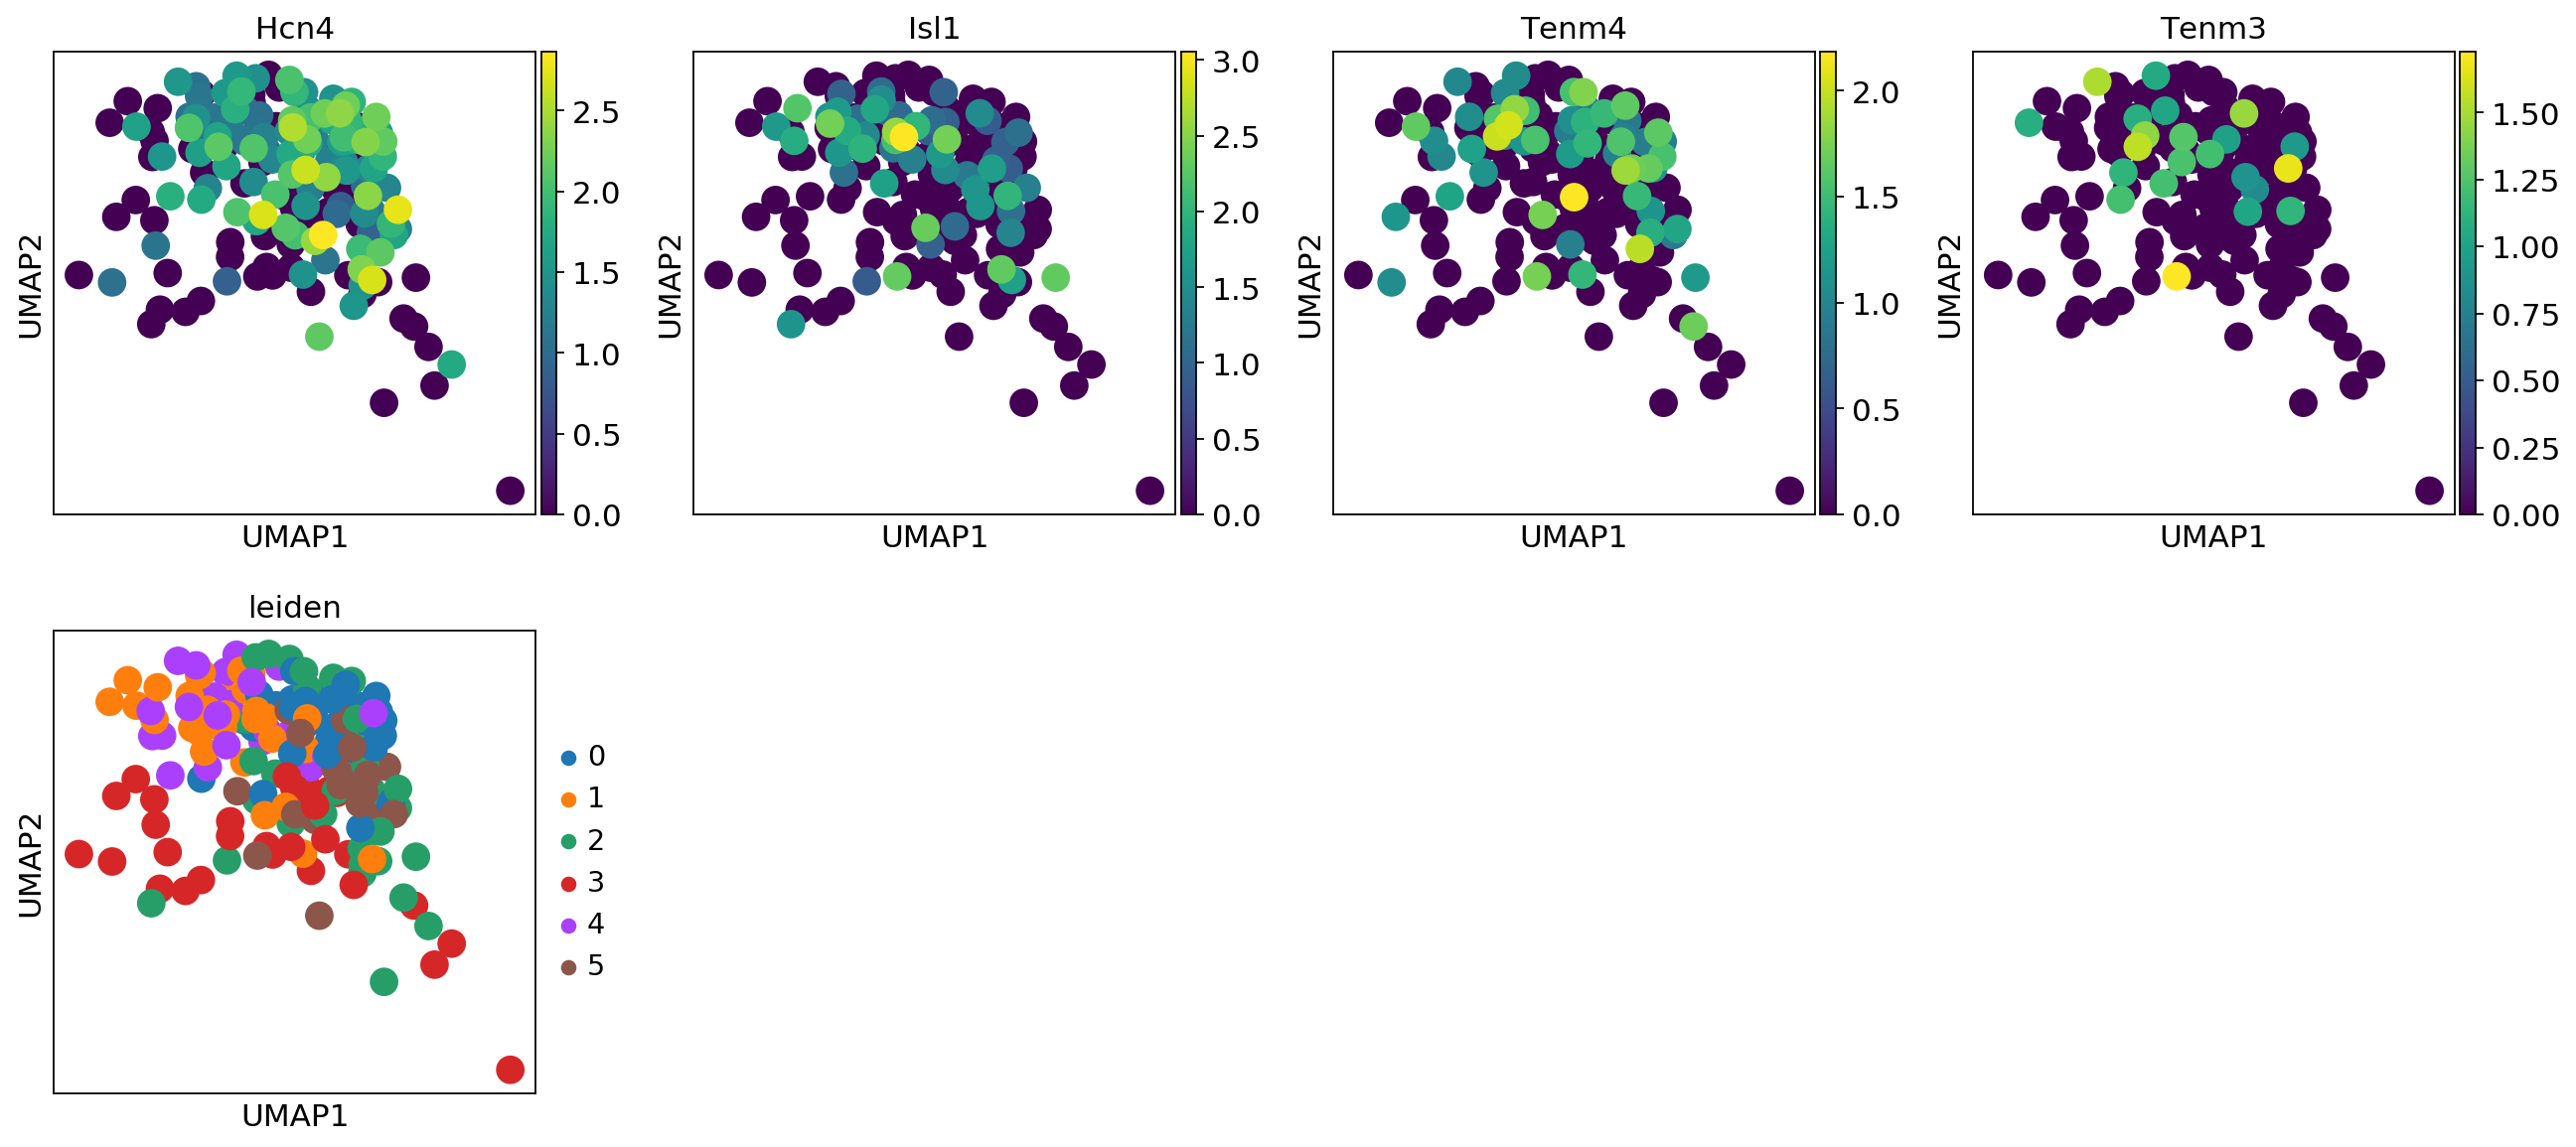

In [57]:
sc.pl.umap(adata_subsubset, color=['Hcn4', 'Isl1','Tenm4','Tenm3','leiden'])